In [1]:
suppressMessages(library(anndataR))
suppressMessages(library(dplyr))
suppressMessages(library(Seurat))

In [2]:
out_dir <- "../../results/11_mac_endo/01_integrate_data"

if(!dir.exists(out_dir)){
    dir.create(out_dir, recursive = TRUE)
}

In [3]:
adata_mac <- anndataR::read_h5ad("../../results/07_marchphages/02_annotate/adata.h5ad")
adata_endo <- anndataR::read_h5ad("../../results/06_endo/04_merge_clusters/endothelial.h5ad")

In [6]:
head(adata_endo$obs)

,patient_id,condition,cell_type,data,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,leiden,sub_clusters,sub_clusters_v2
,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1757,pt03031,SSc,Endothelial,Gur2022,1399,7.244228,2129.710,7.664210,8.808879,15.75686,26.20924,49.36440,42.82553,2.010862,2,Endo3,VenEC
1759,pt03031,SSc,Endothelial,Gur2022,921,6.826545,1882.764,7.541028,9.823344,17.73181,30.84734,60.53835,41.86559,2.223623,1,Endo2,VenEC
1760,pt03031,SSc,Endothelial,Gur2022,1333,7.195937,2253.614,7.720734,8.132626,14.57819,25.16733,48.54739,44.36490,1.968611,1,Endo2,VenEC
1761,pt03031,SSc,Endothelial,Gur2022,367,5.908083,1074.742,6.980766,18.205389,32.81134,57.97558,99.99976,52.61740,4.895816,4,Endo5,VenEC
1776,pt03031,SSc,Endothelial,Gur2022,758,6.632002,1719.643,7.450453,11.049687,19.94320,35.22104,70.14931,42.53326,2.473377,2,Endo3,VenEC
1778,pt03031,SSc,Endothelial,Gur2022,943,6.850126,1912.942,7.556920,9.797241,17.58053,30.46263,60.01670,39.17355,2.047817,2,Endo3,VenEC


In [4]:
df_obs_mac <- adata_mac$obs %>%
    subset(select = c(patient_id, condition, cell_type, data, annotation)) %>%
    dplyr::rename(sub_clusters = annotation)

In [10]:
df_obs_endo <- adata_endo$obs %>%
    subset(select = c(patient_id, condition, cell_type, data, sub_clusters_v2)) %>%
    dplyr::rename("sub_clusters" = "sub_clusters_v2")

In [11]:
head(df_obs_mac)

,patient_id,condition,cell_type,data,sub_clusters
,<fct>,<fct>,<fct>,<fct>,<fct>
49474,pt03006,SSc,Macrophages,Gur2022,Phagocytic
49483,pt03006,SSc,Macrophages,Gur2022,Antigen-presenting
56073,pt03013,SSc,Macrophages,Gur2022,Antigen-presenting
56152,pt03013,SSc,Macrophages,Gur2022,Antigen-presenting
56167,pt03013,SSc,Macrophages,Gur2022,Antigen-presenting
56170,pt03013,SSc,Macrophages,Gur2022,Pro-inflammatory


In [12]:
head(df_obs_endo)

,patient_id,condition,cell_type,data,sub_clusters
,<fct>,<fct>,<fct>,<fct>,<fct>
1757,pt03031,SSc,Endothelial,Gur2022,VenEC
1759,pt03031,SSc,Endothelial,Gur2022,VenEC
1760,pt03031,SSc,Endothelial,Gur2022,VenEC
1761,pt03031,SSc,Endothelial,Gur2022,VenEC
1776,pt03031,SSc,Endothelial,Gur2022,VenEC
1778,pt03031,SSc,Endothelial,Gur2022,VenEC


In [13]:
counts = rbind(adata_mac$layers$counts, adata_endo$layers$counts)

In [14]:
colnames(counts) <- adata_mac$var_names

In [15]:
metadata = rbind(df_obs_mac, df_obs_endo)

In [16]:
obj <- CreateSeuratObject(counts = t(counts), meta.data = metadata)

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”


In [17]:
obj

An object of class Seurat 
15275 features across 7344 samples within 1 assay 
Active assay: RNA (15275 features, 0 variable features)
 1 layer present: counts

In [18]:
obj <- obj %>%
    NormalizeData() %>%
    FindVariableFeatures() %>%
    ScaleData() %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


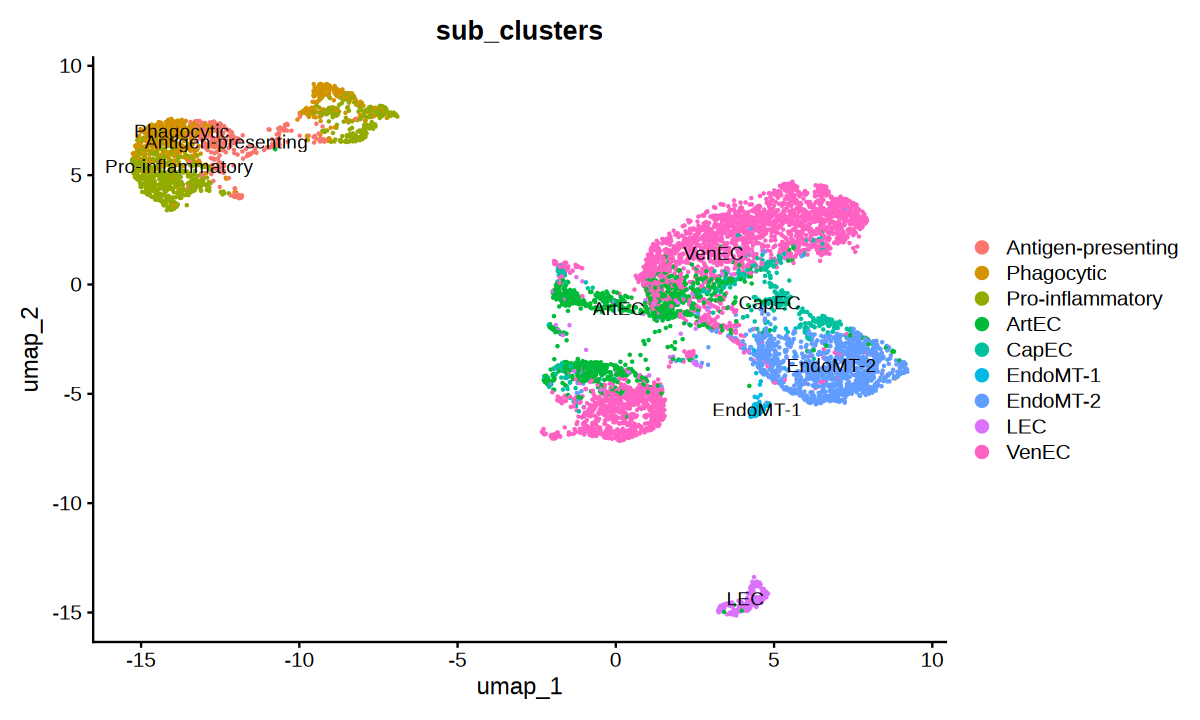

In [19]:
options(repr.plot.height = 6, repr.plot.width = 10)

DimPlot(obj, group.by = "sub_clusters", label = TRUE)

In [20]:
saveRDS(obj, glue::glue("{out_dir}/obj.rds"))